In [2]:
import os
import urllib, cStringIO

import pymongo as pm

from IPython.display import clear_output

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)   

### load in model param posterior (bdaOutput/**splitbyobjectParams.csv)

#### make loglikelihood plot for human encoder version

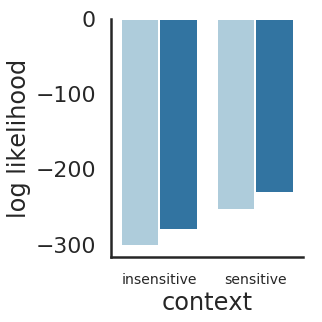

In [3]:
model_prefixes = ['human']
PP = h.model_comparison_bars(model_prefixes,adaptor_type='human')
h.plot_human_bars(PP)

In [4]:
PP

,model,logLikelihood,perception,pragmatics,production
0,human_S0_cost,-280.872004,human,S0,cost
1,human_S0_nocost,-302.543329,human,S0,nocost
2,human_combined_cost,-232.667310,human,combined,cost
3,human_combined_nocost,-254.589197,human,combined,nocost


#### make loglikelihood plot for multimodal convnet encoder version

In [5]:
adaptor_type = 'multimodal_fc6'
split_type = 'balancedavg1'
model_prefixes = [adaptor_type]
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_fc6_S0_cost,-565.695717,multimodal,fc6,S0,cost
1,multimodal_fc6_S0_nocost,-567.651735,multimodal,fc6,S0,nocost
2,multimodal_fc6_combined_cost,-479.642148,multimodal,fc6,combined,cost
3,multimodal_fc6_combined_nocost,-485.533552,multimodal,fc6,combined,nocost


In [6]:
adaptor_type = 'multimodal_conv42'
split_type = 'balancedavg1'
model_prefixes = ['multimodal_conv42']
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_conv42_S0_cost,-761.169886,multimodal,conv42,S0,cost
1,multimodal_conv42_S0_nocost,-764.507610,multimodal,conv42,S0,nocost
2,multimodal_conv42_combined_cost,-761.189535,multimodal,conv42,combined,cost
3,multimodal_conv42_combined_nocost,-707.762607,multimodal,conv42,combined,nocost


In [7]:
adaptor_type = 'multimodal_pool1'
split_type = 'balancedavg1'
# model_prefixes = ['multimodal_pool1','multimodal_conv42','multimodal_fc6']
model_prefixes = ['multimodal_pool1']
PP = h.model_comparison_bars(model_prefixes,adaptor_type=adaptor_type,split_type=split_type)
# h.plot_multimodal_bars(PP)
PP

,model,logLikelihood,adaptor,perception,pragmatics,production
0,multimodal_pool1_S0_cost,-1125.238673,multimodal,pool1,S0,cost
1,multimodal_pool1_S0_nocost,-1125.261847,multimodal,pool1,S0,nocost
2,multimodal_pool1_combined_cost,-1108.363346,multimodal,pool1,combined,cost
3,multimodal_pool1_combined_nocost,-1108.785184,multimodal,pool1,combined,nocost


#### check that distribution of log likelihoods is higher for the cost version of the model vs. nocost version

In [8]:
reallyRun = 0
if reallyRun:
    h.check_mean_LL_for_cost_vs_nocost(model_prefixes=['multimodal_fc6'],
                                         adaptor_type = 'multimodal_fc6',
                                         split_type='balancedavg1',
                                         plot=True)

### Run evaluate to get scores on the test set

In [9]:
### FIRST STEP:
### iterate through Params and write back out in "flattened" form
reload(h)
reallyRun = 0
if reallyRun:
    h.flatten_param_posterior(adaptor_types = ['multimodal_pool1','multimodal_conv42','multimodal_fc6', 'human'],
                              verbosity=1)

In [10]:
#### SECOND STEP: Go to RSA.py and run evaluate on all of the models and splits
### e.g.,
### python RSA.py --wppl evaluate --perception human --pragmatics combined --production cost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_fc6 --pragmatics combined --production cost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_conv42 --pragmatics combined --production cost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_fc6 --pragmatics S0 --production cost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5
### python RSA.py --wppl evaluate --perception multimodal_fc6 --pragmatics combined --production nocost --split_type balancedavg1 balancedavg2 balancedavg3 balancedavg4 balancedavg5

In [11]:
### OPTIONAL: prior to running bda-enumerate, wouldn't it help to get a sense for the extreme values
### in the param posterior for each model, for each split to make sure our grid covers 
### everywhere where there is some mass in the posterior?
reload(h)
reallyRun = 0
if reallyRun:
    h.get_sense_for_param_range_across_splits()

## check model predictions 

- Run the script `./get_all_model_predictions.py`, which is a wrapper around 
this script, `./generate_model_predictions.py` to generate csv files that 
summarize key statistics of interest (e.g., target rank, cost)
from model predictions, for each model and data split.
- Next, assess retrieval performance (i.e., rank of correct sketch category)
- Also assess sketch cost across conditions

#### now read in predictions and compute retrieval performance

In [69]:
###### TODO: to make sure we preserve correspondence for plotting below, but delete once you have set up the 
###### plotting pipeline
# H = pd.read_csv('./csv/human_combined_cost_balancedavg1_predictions.csv')
# M = pd.read_csv('./csv/multimodal_fc6_combined_cost_balancedavg1_predictions.csv')
# M0 = pd.read_csv('./csv/multimodal_conv42_combined_cost_balancedavg1_predictions.csv')
# M1 = pd.read_csv('./csv/multimodal_fc6_S0_cost_balancedavg1_predictions.csv')
# M2 = pd.read_csv('./csv/multimodal_fc6_combined_nocost_balancedavg1_predictions.csv')

In [38]:
import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.py'>

In [14]:
### Load all model predictions from all five splits
### P is a nested dictionary containing all predictions dataframes for all five primary models of interest and five splits.
### P.keys() = ['multimodal_conv42_combined_cost', 'human_combined_cost', 'multimodal_fc6_combined_cost', 'multimodal_fc6_S0_cost', 'multimodal_fc6_combined_nocost']
### Nested inside each model's key are each split.
P = h.load_all_model_preds()

Loading model preds from: human_combined_cost
Loading split balancedavg1
Loading split balancedavg2
Loading split balancedavg3
Loading split balancedavg4
Loading split balancedavg5
Loading model preds from: multimodal_fc6_combined_cost
Loading split balancedavg1
Loading split balancedavg2
Loading split balancedavg3
Loading split balancedavg4
Loading split balancedavg5
Loading model preds from: multimodal_conv42_combined_cost
Loading split balancedavg1
Loading split balancedavg2
Loading split balancedavg3
Loading split balancedavg4
Loading split balancedavg5
Loading model preds from: multimodal_fc6_S0_cost
Loading split balancedavg1
Loading split balancedavg2
Loading split balancedavg3
Loading split balancedavg4
Loading split balancedavg5
Loading model preds from: multimodal_fc6_combined_nocost
Loading split balancedavg1
Loading split balancedavg2
Loading split balancedavg3
Loading split balancedavg4
Loading split balancedavg5


In [ ]:
# for i in np.arange(1,6):
#     _P = P['human_combined_cost']['balancedavg{}'.format(i)]
#     print _P.groupby('condition')['cost'].mean()

In [16]:
print P.keys()

['multimodal_conv42_combined_cost', 'human_combined_cost', 'multimodal_fc6_combined_cost', 'multimodal_fc6_S0_cost', 'multimodal_fc6_combined_nocost']


### Visualize model predictions separately for each split

- `split_types = ['balancedavg1','balancedavg2','balancedavg3','balancedavg4','balancedavg5']`

- `model_space = ['human_combined_cost','multimodal_fc6_combined_cost','multimodal_conv42_combined_cost',`
`'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost']`

- `H = human_combined_cost`
- `M = multimodal_fc6_combined_cost`
- `M0 = multimodal_conv42_combined_cost` 
    - "effect of perception"
- `M1 = multimodal_fc6_S0_cost` 
    - "effect of pragmatics/context"
- `M2 = multimodal_fc6_combined_nocost` 
    - "effect of production/cost"

In [64]:
import analysis_helpers as h
reload(h)
sns.set_context('talk')

split_type = 'balancedavg1'

In [70]:
print h.plot_target_vs_foil_rank_by_object.__doc__


    What is the rank of the correct sketch category (correct object + correct context) 
    vs. wrong sketch category (correct object + wrong context)?
    


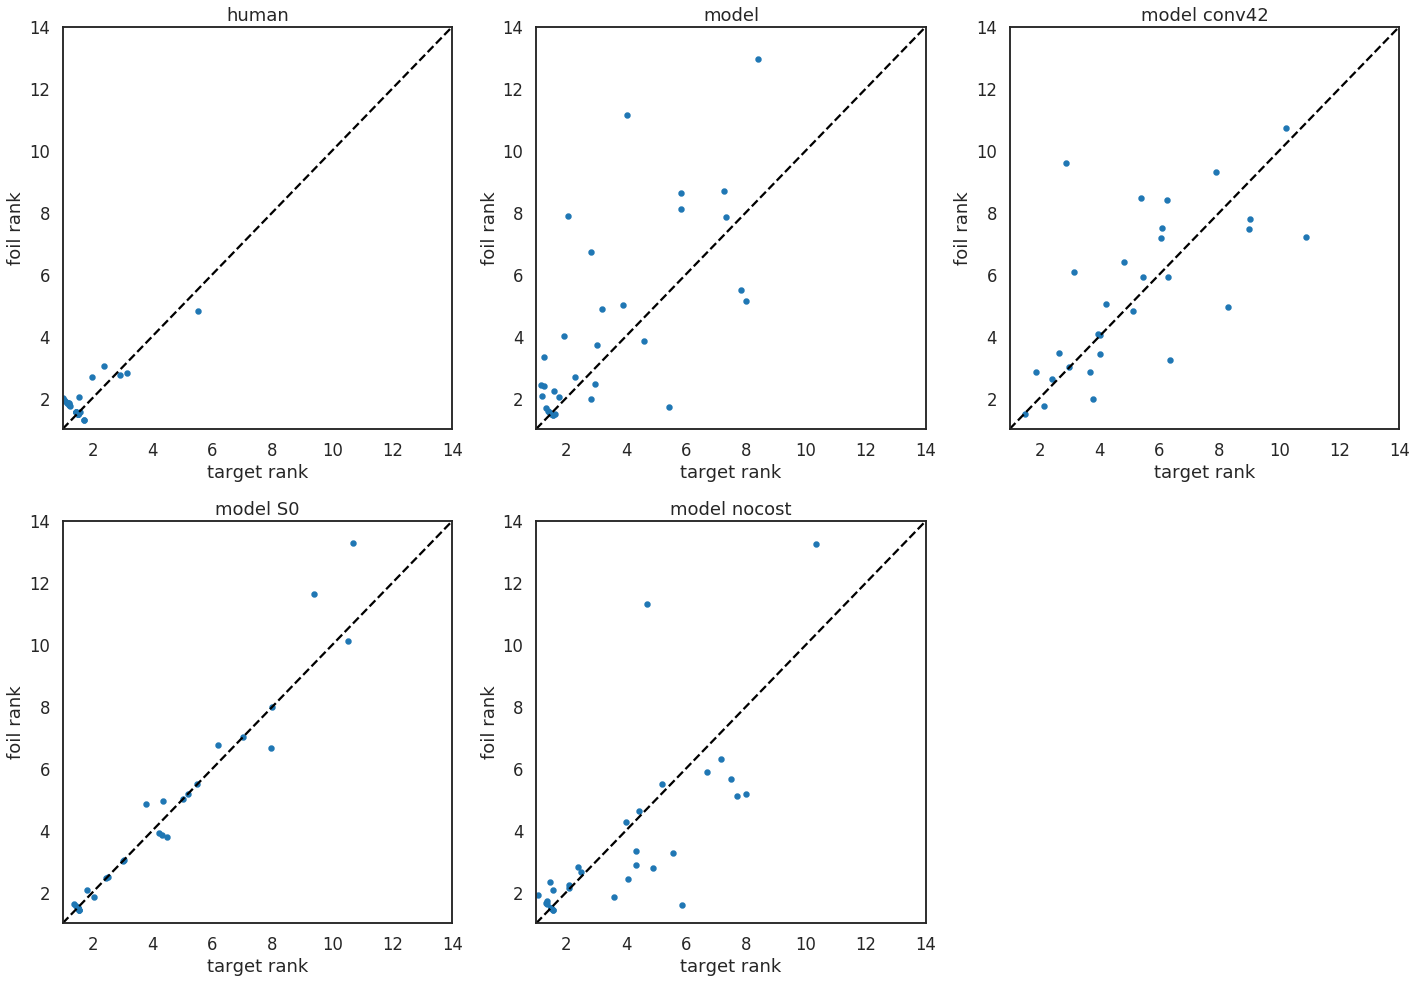

In [71]:
## plot it
h.plot_target_vs_foil_rank_by_object(P,split_type=split_type)

In [79]:
import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.py'>

In [80]:
print h.plot_avg_rank_all_models.__doc__


    Generate bar plot of average rank (out of 64) of correct sketch category, by model, for a particular split.
    Wrapper around get_avg_rank_all_models, which itself wraps around get_avg_rank_across_samples.
    


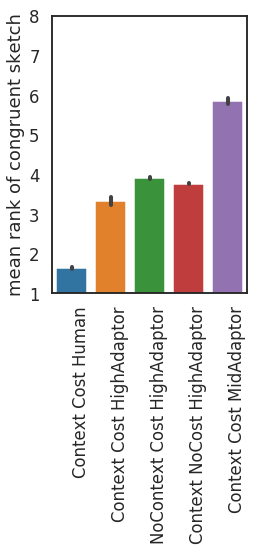

In [81]:
h.plot_avg_rank_all_models(P,split_type=split_type)

In [86]:
def get_prop_congruent(X):
    '''
    make another data frame that computes, for each MCMC sample, the proportion of trials 
    on which model assigns better rank to congruent sketch than sketch from opposite context category ('foil')
    '''
    XM = pd.DataFrame(X.groupby('sample_ind')['sign_diff_rank'].apply(lambda x: sum(x)/len(x))).reset_index()
    adaptor = np.unique(X['adaptor'].values)[0]
    adaptor = list(np.tile(adaptor,len(XM)))
    XM = XM.assign(adaptor=pd.Series(adaptor).values)    
    return XM

HD,MD,M0D,M1D,M2D = map(get_prop_congruent,[H,M,M0,M1,M2])

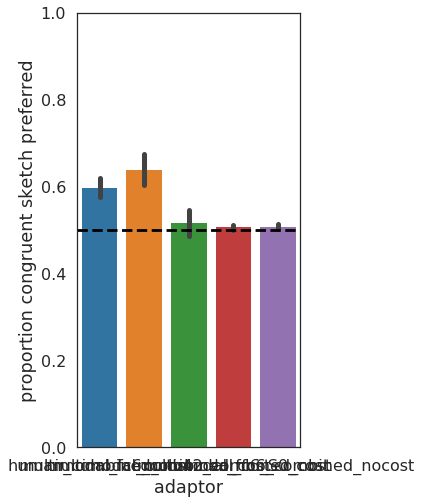

In [115]:
## plot proportion of trials for which context-congruent sketch preferred over incongruent sketch
D = pd.concat([HD,MD,M0D,M1D,M2D],axis=0)
fig = plt.figure(figsize=(4,8))
sns.barplot(data=D,
            x='adaptor',
            y='sign_diff_rank',ci='sd')
plt.axhline(y=0.5,linestyle='dashed',color='k')
plt.ylim([0,1])
plt.ylabel('proportion context-congruent sketch preferred')

xticklabels=['Context Cost Human','Context Cost HighAdaptor',
             'NoContext Cost HighAdaptor','Context NoCost HighAdaptor',
             'Context Cost MidAdaptor']
plt.xlabel('')
l = ax.set_xticklabels(xticklabels, rotation = 90, ha="left")

In [752]:
### make a "top-k" plot (what percentage of sketches in the top k)

model_space = ['human_combined_cost','multimodal_fc6_combined_cost','multimodal_conv42_combined_cost',
              'multimodal_fc6_S0_cost','multimodal_fc6_combined_nocost']

dfs = H,M,M0,M1,M2

model_df_dict = dict(zip(model_space,dfs))

for j,model in enumerate(model_space):
    print '{} evaluating {}'.format(j,model)
    clear_output(wait=True)        
    D = model_df_dict[model]   
    
    sample_inds = np.unique(D.sample_ind.values)
    prop = []
    sid = []
    K = []
    for i,sample_ind in enumerate(sample_inds):
        if i%250==0:
            print 'evaluating {}'.format(i)
        these_rows = D[D['sample_ind']==sample_ind]
        num_trials = these_rows.shape[0]
        for k in np.arange(1,65):
            prop.append(sum(these_rows['target_rank']<=k)/num_trials)
            sid.append(sample_ind)
            K.append(k)

    ## make dataframe and save out
    sid = map(int,sid)
    K = map(int,K)
    adaptor = list(np.tile(model,len(sid)))
    Q = pd.DataFrame([prop,sid,K,adaptor])
    Q = Q.transpose()
    Q.columns = ['prop','ind','k','adaptor']
    print model, split_type
    Q.to_csv('./csv/{}_{}_topk.csv'.format(model,split_type),index=False)        

evaluating 750
multimodal_fc6_combined_nocost balancedavg1


In [6]:
## aggregate across comparison models
QH = pd.read_csv('./csv/human_combined_cost_balancedavg1_topk.csv')
QM = pd.read_csv('./csv/multimodal_fc6_combined_cost_balancedavg1_topk.csv')
QM0 = pd.read_csv('./csv/multimodal_conv42_combined_cost_balancedavg1_topk.csv')
QM1 = pd.read_csv('./csv/multimodal_fc6_S0_cost_balancedavg1_topk.csv')
QM2 = pd.read_csv('./csv/multimodal_fc6_combined_nocost_balancedavg1_topk.csv')
Q = pd.concat([QH,QM0,QM1,QM2,QM],axis=0)

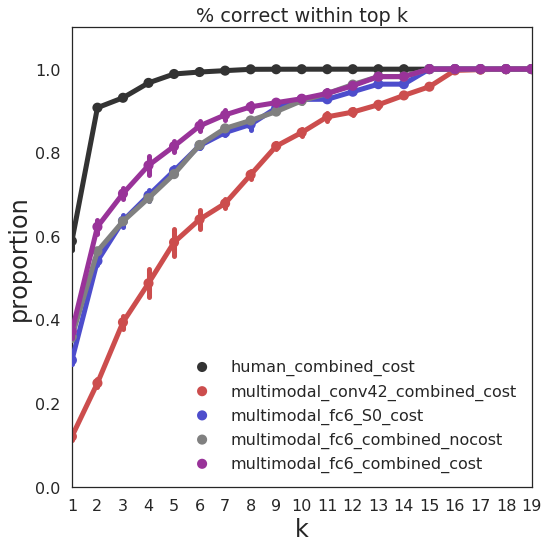

In [24]:
## plot it
krange = 64 ## how many values of k to plot
sns.set_context('poster')
fig = plt.figure(figsize=(8,8))
colors = [(0.2,0.2,0.2),(0.8,0.3,0.3),(0.3,0.3,0.8),(0.5,0.5,0.5),(0.6,0.2,0.6)]
sns.pointplot(x='k',
              y='prop',
              hue='adaptor',
              data=Q,
              palette=colors,
              markers = '.',
              ci='sd',              
              join=True)
plt.ylabel('proportion',fontsize=24)
plt.xlabel('k',fontsize=24)
plt.title('% correct within top k')
plt.ylim([0,1.1])
# plt.xlim([-0.1,krange])
plt.xlim([0,18])
# locs, labels = plt.xticks(np.linspace(0,krange-1,9),map(int,np.linspace(0,krange-1,9)+1),fontsize=16)
plt.tight_layout()
plt.legend()

In [ ]:
import analysis_helpers as h
reload(h)

In [ ]:
### show the average cost (time, strokes, ink) for average model prediction

In [80]:
split_type = 'balancedavg1'
path_to_costs = '/home/jefan/visual_communication_in_context/models/refModule/json/{}/costs-fixedPose96-cost_duration-average.json'.format(split_type)

In [86]:
J = h.load_json(path_to_costs)

<module 'analysis_helpers' from 'analysis_helpers.py'>

In [ ]:
def get_avg_cost_across_samples(X):
    '''
    make another dataframe which computes, for each MCMC sample, the average sketch cost produced
    '''
    XM = pd.DataFrame(X.groupby('sample_ind')['cost'].mean()).reset_index()
    adaptor = np.unique(X['adaptor'].values)[0]
    adaptor = list(np.tile(adaptor,len(XM)))
    XM = XM.assign(adaptor=pd.Series(adaptor).values)    
    return XM
                      

In [107]:
M[M['sample_ind']==0]

,Unnamed: 0,object,condition,target_rank,foil_rank,logprob,sample_ind,trial,cost,diff_rank,sign_diff_rank,adaptor
0,0,robin,further,2,10,-2.473457,0,08711b390cfc_14,0.152723,-8,True,multimodal_fc6_combined_cost
1,1,white,further,1,4,-1.928706,0,08711b390cfc_32,0.146757,-3,True,multimodal_fc6_combined_cost
2,2,basset,closer,1,3,-1.970451,0,08711b390cfc_9,0.161908,-2,True,multimodal_fc6_combined_cost
3,3,crow,closer,1,4,-1.682643,0,0934a9585321_19,0.254296,-3,True,multimodal_fc6_combined_cost
4,4,waiting,further,2,1,-1.533886,0,0934a9585321_29,0.172167,1,False,multimodal_fc6_combined_cost
5,5,bullmastiff,further,3,5,-2.252685,0,0dae8776ef1b_29,0.156056,-2,True,multimodal_fc6_combined_cost
6,6,nightingale,further,4,5,-2.321971,0,0dae8776ef1b_7,0.152808,-1,True,multimodal_fc6_combined_cost
7,7,squat,further,2,1,-1.769842,0,0f3dadf71345_11,0.232055,1,False,multimodal_fc6_combined_cost
8,8,sling,further,2,1,-2.150160,0,0f3dadf71345_13,0.206089,1,False,multimodal_fc6_combined_cost
9,9,white,further,1,4,-1.926129,0,0f3dadf71345_14,0.146654,-3,True,multimodal_fc6_combined_cost
